# Goal
- solve 
$$
\argmin_{\lambda} ||\Gamma - \Gamma_0||_F^2 \\
\text{s.t.} \\
\Gamma = \lambda \Gamma_0 + \mu_y\mu_x^T - \lambda \mu_{y_0}\mu_x^T \\
\mathbb{1}^T\Gamma = \mu_x^T \\
\Gamma \mathbb{1}= \mu_y \\
\Gamma_{ij} \geq 0 \\
\sum_{ij} \Gamma_{ij} = 1 \\
\text{where} \\
\mathbb{1}^T\Gamma_0 = \mu_x^T \\
\Gamma_0 \mathbb{1} = \mu_{y_0} \\
$$

# imports

In [ ]:
import cvxpy as cp
import numpy as np
import matplotlib.pyplot as plt

# cvx LP

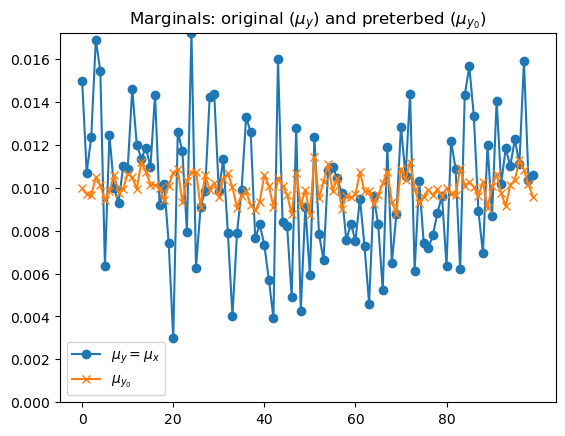

In [440]:
# Define epsilon
n = 100
eps = 0.3 / n  # Define epsilon as a parameter to allow flexibility

# Define constants
Gamma_0 = (1 / n) * np.eye(n)
# mu_x = (1/n) * np.ones(n)
# mu_y0 = mu_x.copy()


# Define a row permutation (e.g., swap row 0 and row 2)
def swap_rows(A):
    perm = np.arange(n)
    np.random.seed(0)
    np.random.shuffle(perm)
    Pi = np.eye(n)[perm]  # Create permutation matrix

    # Apply permutation
    return Pi @ A


# Gamma_0 = swap_rows(Gamma_0)

noise_eps = 0.01
joint_dist_noise = noise_eps * np.abs(np.random.rand(n, n))
Gamma_0 += joint_dist_noise
Gamma_0 /= Gamma_0.sum()

mu_x = Gamma_0.sum(axis=0)
mu_y0 = Gamma_0.sum(axis=1)
np.random.seed(0)
noise = np.random.normal(0, eps, n)
mu_y = np.abs(mu_y0 + noise)
mu_y /= mu_y.sum()


# plot muy and muy0
plt.figure()
plt.plot(mu_y, label=r"$\mu_y = \mu_x$", marker="o")
plt.plot(mu_y0, label=r"$\mu_{y_0}$", marker="x")
plt.legend()
plt.ylim([0, max(mu_y0.max(), mu_y.max())])
plt.xticks(range(0, n, n // 5))
plt.title(r"Marginals: original ($\mu_y$) and preterbed ($\mu_{y_0}$)")
plt.show()

In [441]:
def solve_for_close_joint_distribution(Gamma_0, mu_x, mu_y, mu_y0):
    # Define variable
    lambda_var = cp.Variable(nonneg=True)
    Gamma = (
        lambda_var * Gamma_0 + np.outer(mu_y, mu_x) - lambda_var * np.outer(mu_y0, mu_x)
    )

    # Define constraints
    constraints = [
        cp.sum(Gamma) == 1,  # Sum constraint
        cp.sum(Gamma, axis=0) == mu_x,  # Column sum constraint
        cp.sum(Gamma, axis=1) == mu_y,  # Row sum constraint
        Gamma >= 0,  # Non-negativity constraint
    ]

    # Define objective
    objective = cp.Minimize(cp.norm(Gamma - Gamma_0, "fro") ** 2)

    # Solve problem
    problem = cp.Problem(objective, constraints)

    # Assign a value to epsilon and solve
    # eps.value = 0.01  # Example value
    problem.solve(solver="CVXOPT")

    # Print results
    if problem.status == "infeasible":
        assert lambda_var.value is None
        print("Problem is infeasible: optimal lambda 0 by definition")
        lambda_opt = 0
    else:
        lambda_opt = lambda_var.value
    Gamma = (
        lambda_opt * Gamma_0 + np.outer(mu_y, mu_x) - lambda_opt * np.outer(mu_y0, mu_x)
    )
    return Gamma, lambda_opt, problem


# # Define variable
# lambda_var = cp.Variable()
# Gamma = lambda_var * Gamma_0 + np.outer(mu_y, mu_x) - lambda_var * np.outer(mu_y0, mu_x)


# # Define constraints
# constraints = [
#     cp.sum(Gamma) == 1,              # Sum constraint
#     cp.sum(Gamma, axis=0) == mu_x,    # Column sum constraint
#     cp.sum(Gamma, axis=1) == mu_y,    # Row sum constraint
#     Gamma >= 0                        # Non-negativity constraint
# ]

# # Define objective
# objective = cp.Minimize(cp.norm(Gamma - Gamma_0, 'fro')**2)

# # Solve problem
# problem = cp.Problem(objective, constraints)

# # Assign a value to epsilon and solve
# # eps.value = 0.01  # Example value
# problem.solve(solver='CVXOPT')

Gamma, lambda_opt, problem = solve_for_close_joint_distribution(
    Gamma_0, mu_x, mu_y, mu_y0
)
# Print results
print("Optimal lambda:", lambda_opt)

Optimal lambda: 0.28325170644642467


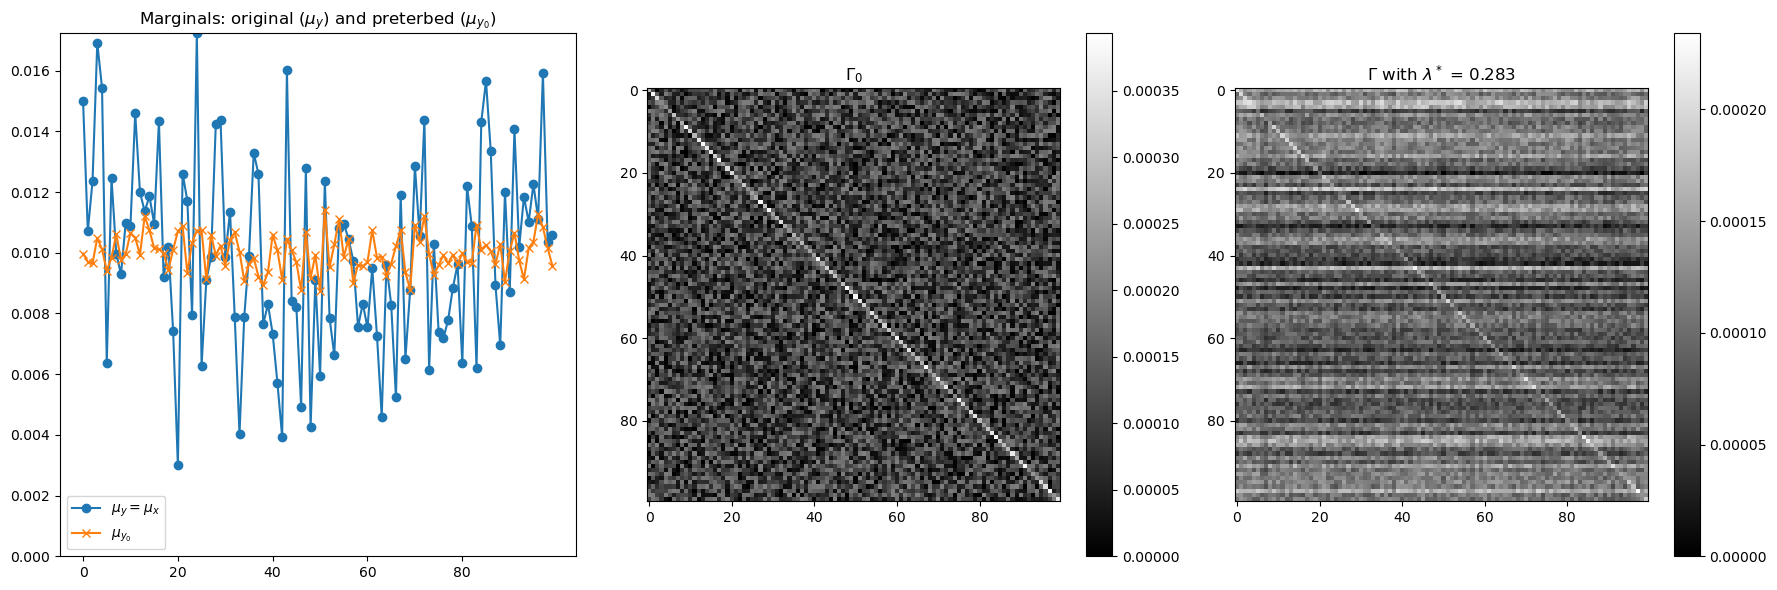

In [442]:
annotate_red_numbers = False
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# plot muy and muy0

idx = 0
axes[idx].plot(mu_y, label=r"$\mu_y = \mu_x$", marker="o")
axes[idx].plot(mu_y0, label=r"$\mu_{y_0}$", marker="x")
axes[idx].legend()
axes[idx].set_ylim([0, max(mu_y0.max(), mu_y.max())])
axes[idx].set_xticks(range(0, n, n // 5))
axes[idx].set_title(r"Marginals: original ($\mu_y$) and preterbed ($\mu_{y_0}$)")


# Plot Gamma_0
idx += 1
im1 = axes[idx].imshow(Gamma_0, cmap="gray", vmin=0, vmax=Gamma_0.max())
fig.colorbar(im1, ax=axes[idx])
axes[idx].set_title(r"$\Gamma_0$")
# Annotate Gamma with numbers
if annotate_red_numbers:
    # Annotate Gamma_0 with numbers
    for i in range(Gamma_0.shape[0]):
        for j in range(Gamma_0.shape[1]):
            axes[idx].text(
                j, i, f"{Gamma_0[i, j]:.2e}", ha="center", va="center", color="red"
            )

# Plot Gamma
idx += 1
im0 = axes[idx].imshow(Gamma, cmap="gray", vmin=0, vmax=Gamma.max())
fig.colorbar(im0, ax=axes[idx])
axes[idx].set_title(r"$\Gamma$ with $\lambda^*$ = {:1.3f}".format(lambda_opt))

# Annotate Gamma with numbers
if annotate_red_numbers:
    for i in range(Gamma.shape[0]):
        for j in range(Gamma.shape[1]):
            axes[idx].text(
                j, i, f"{Gamma[i, j]:.2e}", ha="center", va="center", color="red"
            )

plt.tight_layout()
plt.show()

## local GW

In [422]:
import torch
import ot

# Set random seed for reproducibility
torch.manual_seed(42)

# Number of points
num_points = n = 20

# Sample random points in 3D
sparse_coordinates_i = torch.rand((num_points, 2))
# sparse_coordinates_j = torch.rand((num_points, 3))
point_eps = 0.02
sparse_coordinates_j = sparse_coordinates_i + point_eps * torch.randn_like(
    sparse_coordinates_i
)

# Compute pairwise distances
pairwise_distances_i = torch.cdist(sparse_coordinates_i, sparse_coordinates_i)
pairwise_distances_j = torch.cdist(sparse_coordinates_j, sparse_coordinates_j)

# Define uniform weights
uniform_weights_i = uniform_weights_j0 = torch.full((num_points,), 1.0 / num_points)

# Compute Gromov-Wasserstein distance
_, log0 = ot.gromov.gromov_wasserstein2(
    pairwise_distances_i.numpy(),  # Cost matrix for source
    pairwise_distances_j.numpy(),  # Cost matrix for target
    uniform_weights_i.numpy(),  # Uniform distribution for source
    uniform_weights_j0.numpy(),  # Uniform distribution for target
    "square_loss",
    log=True,
)

# Print result
print("Gromov-Wasserstein distance:", log0["gw_dist"])

Gromov-Wasserstein distance: 0.0006969012320041656


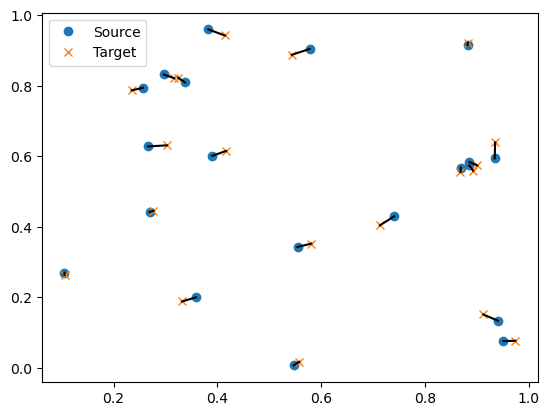

In [423]:
sparse_coordinates_i_np = sparse_coordinates_i.numpy()
sparse_coordinates_j_np = sparse_coordinates_j.numpy()


plt.plot(
    sparse_coordinates_i_np[:, 0], sparse_coordinates_i_np[:, 1], "o", label="Source"
)
plt.plot(
    sparse_coordinates_j_np[:, 0], sparse_coordinates_j_np[:, 1], "x", label="Target"
)
plt.legend()

# connect with lines from joint distribution transport plan
for i in range(num_points):
    for j in range(num_points):
        if log0["T"][i, j] > 0.5 / n:
            plt.plot(
                [sparse_coordinates_i_np[i, 0], sparse_coordinates_j_np[j, 0]],
                [sparse_coordinates_i_np[i, 1], sparse_coordinates_j_np[j, 1]],
                "k",
                alpha=1,
            )

In [351]:
# gw = 0
# for i in range(num_points):
#     for j in range(num_points):
#         for k in range(num_points):
#             for l in range(num_points):
#                 gw += (pairwise_distances_i[i,j] - pairwise_distances_j[k,l])**2 * log['T'][i,k] * log['T'][j,l]


In [428]:
torch.manual_seed(0)
eps = 0 * 0.01 / n
uniform_weights_j = uniform_weights_j0 + eps * torch.randn_like(uniform_weights_j0)
uniform_weights_j = torch.abs(uniform_weights_j)
uniform_weights_j /= uniform_weights_j.sum()

# Compute Gromov-Wasserstein distance
_, log = ot.gromov.gromov_wasserstein2(
    pairwise_distances_i.numpy(),  # Cost matrix for source
    pairwise_distances_j.numpy(),  # Cost matrix for target
    uniform_weights_i.numpy(),  # Uniform distribution for source
    uniform_weights_j.numpy(),  # Uniform distribution for target
    "square_loss",
    log=True,
)

# Print result
print("Gromov-Wasserstein distance:", log["gw_dist"])

Gromov-Wasserstein distance: 0.0006967559456825256


In [429]:
mu_x = uniform_weights_i.numpy()
mu_y0 = uniform_weights_j0.numpy()
mu_y = uniform_weights_j.numpy()
Gamma_0 = log0["T"]
Gamma_gwsolved_local = log["T"]

In [430]:
Gamma_closefro, lambda_opt, problem = solve_for_close_joint_distribution(
    Gamma_0, mu_x, mu_y, mu_y0
)

Problem is infeasible: optimal lambda 0 by definition


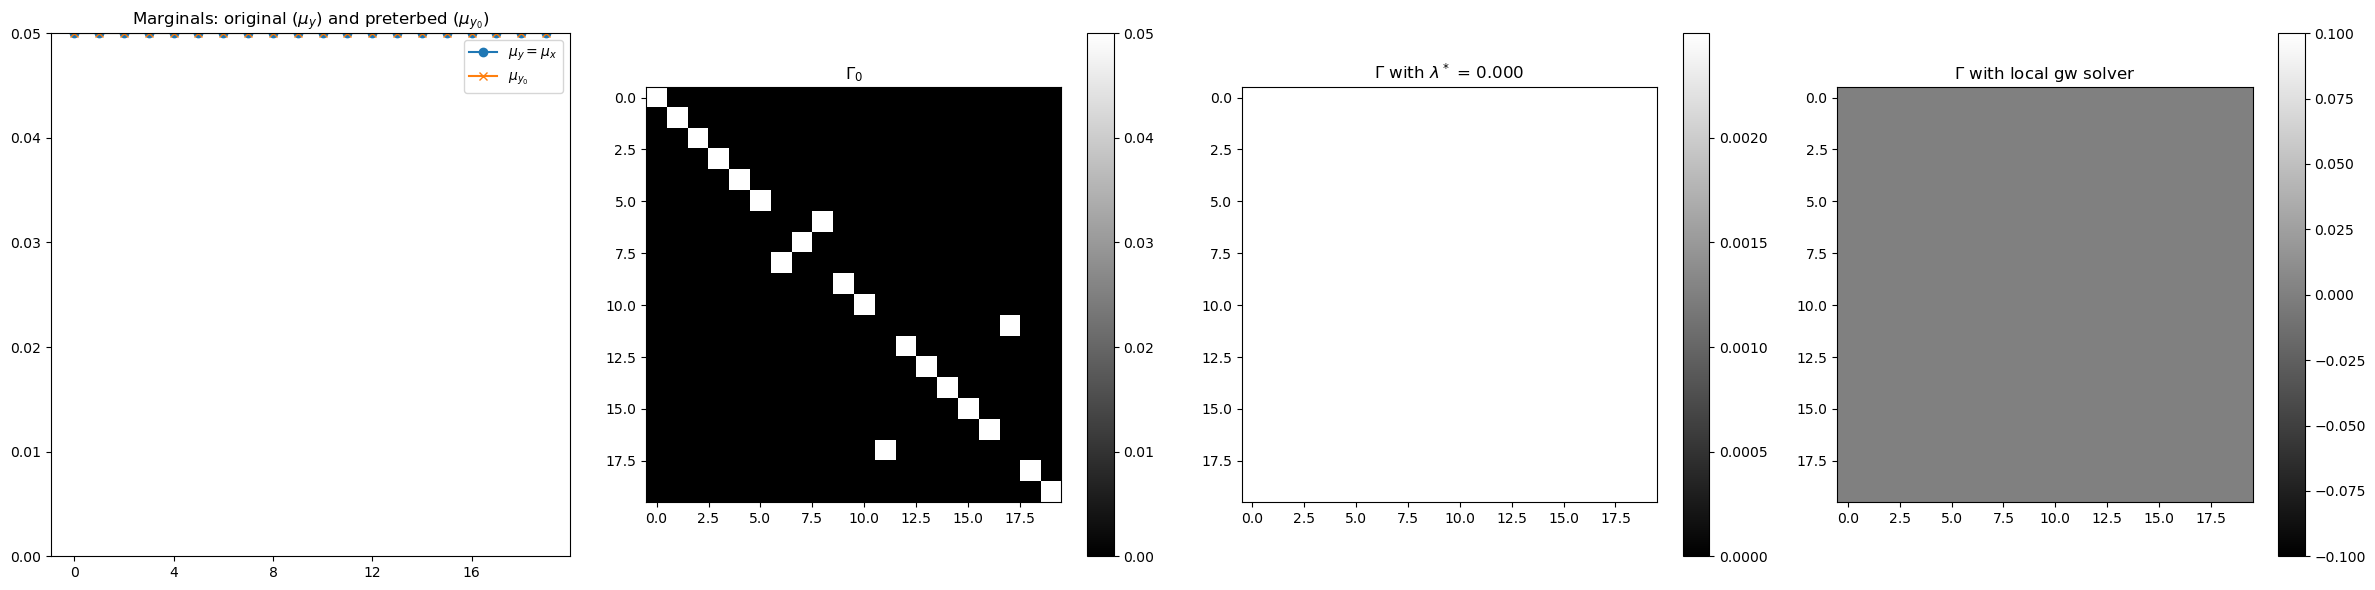

In [431]:
annotate_red_numbers = False
fig, axes = plt.subplots(1, 4, figsize=(24, 6))

# plot muy and muy0

idx = 0
axes[idx].plot(mu_y, label=r"$\mu_y = \mu_x$", marker="o")
axes[idx].plot(mu_y0, label=r"$\mu_{y_0}$", marker="x")
axes[idx].legend()
axes[idx].set_ylim([0, max(mu_y0.max(), mu_y.max())])
axes[idx].set_xticks(range(0, n, n // 5))
axes[idx].set_title(r"Marginals: original ($\mu_y$) and preterbed ($\mu_{y_0}$)")


# Plot Gamma_0
idx += 1
im1 = axes[idx].imshow(Gamma_0, cmap="gray", vmin=0, vmax=Gamma_0.max())
fig.colorbar(im1, ax=axes[idx])
axes[idx].set_title(r"$\Gamma_0$")
# Annotate Gamma with numbers
if annotate_red_numbers:
    # Annotate Gamma_0 with numbers
    for i in range(Gamma_0.shape[0]):
        for j in range(Gamma_0.shape[1]):
            axes[idx].text(
                j, i, f"{Gamma_0[i, j]:.2e}", ha="center", va="center", color="red"
            )

# Plot Gamma
idx += 1
im0 = axes[idx].imshow(Gamma_closefro, cmap="gray", vmin=0, vmax=Gamma_closefro.max())
fig.colorbar(im0, ax=axes[idx])
axes[idx].set_title(r"$\Gamma$ with $\lambda^*$ = {:1.3f}".format(lambda_opt))

# Annotate Gamma with numbers
if annotate_red_numbers:
    for i in range(Gamma_closefro.shape[0]):
        for j in range(Gamma_closefro.shape[1]):
            axes[idx].text(
                j,
                i,
                f"{Gamma_closefro[i, j]:.2e}",
                ha="center",
                va="center",
                color="red",
            )

# Plot Gamma
idx += 1
im0 = axes[idx].imshow(
    Gamma_0 - Gamma_gwsolved_local, cmap="gray"
)  # vmin=0, vmax=Gamma_gwsolved_local.max())
fig.colorbar(im0, ax=axes[idx])
axes[idx].set_title(r"$\Gamma$ with local gw solver")

# Annotate Gamma with numbers
if annotate_red_numbers:
    for i in range(Gamma_gwsolved_local.shape[0]):
        for j in range(Gamma_gwsolved_local.shape[1]):
            axes[idx].text(
                j,
                i,
                f"{Gamma_gwsolved_local[i, j]:.2e}",
                ha="center",
                va="center",
                color="red",
            )

plt.tight_layout()
plt.show()